Intructional Finetuning: Prepare dataset -> Finetunee -> Evaluate.

In [30]:
import torch 
from tqdm import tqdm
import re
import psutil
import os
import time
import tiktoken
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from gpt_download import download_and_load_gpt2
from Pretraining import GPTModel
from GPT2 import load_weights_into_gpt
from GPT_architecture import Generate_text
from Pretraining import text_to_token_ids, token_ids_to_txt, generate
from Pretraining import (
        calc_loss_loader,
        train_model_simple,
        plot_losses,
        generate_and_print_sample
)

In [2]:
# current dataset has instruction, i/p, respone. I am using Alpaca prompt, hihi
def format_input(entry):
    instruction_text = (
            f"Below is an instruction that describes a task. "
            f"Write a response that appropriately completes the request."
            f"\n\n## Instruction:\n{entry['instruction']}"
            )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [3]:
import pandas as pd
data= pd.read_json("instruction-data.json")
data.head()

,instruction,input,output
0,Evaluate the following phrase by transforming ...,freind --> friend,"The spelling of the given phrase ""freind"" is i..."
1,Edit the following sentence for grammar.,He go to the park every day.,He goes to the park every day.
2,Convert 45 kilometers to meters.,,45 kilometers is 45000 meters.
3,Rewrite this sentence to start with 'Although'...,,"Although it was raining, they went for a walk."
4,What are the first 10 square numbers?,,"1, 4, 9, 16, 25, 36, 49, 64, 81, 100."


In [4]:
model_ip= format_input(data.iloc[1])
desired_output= f"\n\n### Respone:\n{data.iloc[1]['output']}"
print(model_ip+ desired_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
Edit the following sentence for grammar.

### Input:
He go to the park every day.

### Respone:
He goes to the park every day.


In [22]:
class Instruction_dataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for _, entry in data.iterrows(): 
            entry = entry.to_dict()
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                    tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [6]:
# custom collate function coz why not? hehe, well it is needed to pad training egs to same len
# but diff batches can have diff lens, this minimizes unnecessary padding.
def custom_collate_draft(
        batch,
        pad_token_id= 50256,
        device= "cpu"
):
    batch_max_length= max(len(item)+1 for item in batch)
    input_lst= []

    for item in batch:
        new_item=item.copy()
        new_item+=[pad_token_id]

        padded=(
            new_item+[pad_token_id]* (batch_max_length-len(new_item))
        )

        inputs= torch.tensor(padded[:-1])
        input_lst.append(inputs)
    
    inputs_tensor= torch.stack(input_lst).to(device)
    return inputs_tensor

In [12]:
ip1= [12,131,12,1,122]
ip2= [90,98,90,1]
ip3=[0]
batch=(ip1, ip2, ip3)
print(custom_collate_draft(batch))

tensor([[   12,   131,    12,     1,   122],
        [   90,    98,    90,     1, 50256],
        [    0, 50256, 50256, 50256, 50256]])


In [7]:
# this custom_collate () is to return target token ids with addition to input token ids
def custom_collate(
        batch,
        pad_token_id= 50256,
        device= "cpu"
):
    batch_max_length= max(len(item)+1 for item in batch)
    input_lst, target_lsts= [],[]

    for item in batch:
        new_item=item.copy()
        new_item+=[pad_token_id]

        padded=(
            new_item+[pad_token_id]* (batch_max_length-len(new_item))
        )

        inputs= torch.tensor(padded[:-1])
        targets= torch.tensor(padded[:-1])

        input_lst.append(inputs)
        target_lsts.append(targets)
    
    inputs_tensor= torch.stack(input_lst).to(device)
    target_tensor= torch.stack(target_lsts).to(device)

    return inputs_tensor, target_tensor

In [18]:
ip1= [12,131,12,1,122]
ip2= [90,98,90,1]
ip3=[0]
batch=(ip1, ip2, ip3)
ips, tar= custom_collate(batch)
print(ips)
print(tar)

tensor([[   12,   131,    12,     1,   122],
        [   90,    98,    90,     1, 50256],
        [    0, 50256, 50256, 50256, 50256]])
tensor([[   12,   131,    12,     1,   122],
        [   90,    98,    90,     1, 50256],
        [    0, 50256, 50256, 50256, 50256]])


In [8]:
# this custom_collate_fn () is to assign -100 to all padding tokens
# why? to make sure they don't contribute to train loss calc
# to ensure only meaningful data influence our cutie model 
# why -100? coz cross_entropy function in pytorch ignores target labeled with -100
def custom_collate_fn(
        batch,
        pad_token_id= 50256,
        ignore_idx=-100,
        allowed_max_len=None,
        device= "cpu"
):
    batch_max_length= max(len(item)+1 for item in batch)
    input_lst, target_lsts= [],[]

    for item in batch:
        new_item=item.copy()
        new_item+=[pad_token_id]

        padded=(
            new_item+[pad_token_id]* (batch_max_length-len(new_item))
        )

        inputs= torch.tensor(padded[:-1])
        targets= torch.tensor(padded[:-1])

        mask = targets == pad_token_id
        indices= torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]]=ignore_idx
        if allowed_max_len is not None:
            inputs= inputs[:allowed_max_len]
            targets= targets[:allowed_max_len]

        input_lst.append(inputs)
        target_lsts.append(targets)
    
    inputs_tensor= torch.stack(input_lst).to(device)
    target_tensor= torch.stack(target_lsts).to(device)

    return inputs_tensor, target_tensor

In [22]:
ip1= [12,131,12,1,122]
ip2= [90,98,90,1]
ip3=[0]
batch=(ip1, ip2, ip3)
ips, tar= custom_collate_fn(batch)
print(ips)
print(tar)

tensor([[   12,   131,    12,     1,   122],
        [   90,    98,    90,     1, 50256],
        [    0, 50256, 50256, 50256, 50256]])
tensor([[   12,   131,    12,     1,   122],
        [   90,    98,    90,     1, 50256],
        [    0, 50256,  -100,  -100,  -100]])


In [9]:
# Splitting into train, val and test 
train_portion = int(len(data) * 0.85) # 85% for train
test_portion = int(len(data) * 0.1) # 10% for test
val_portion = len(data) - train_portion - test_portion # 5% for val

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set len:", len(train_data))
print("Validation set len:", len(val_data))
print("Test set len:", len(test_data))

Training set len: 935
Validation set len: 55
Test set len: 110


In [11]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [21]:
print(type(train_data.iloc[1]))
print(train_data.iloc[1])

<class 'pandas.core.series.Series'>
instruction    Edit the following sentence for grammar.
input                      He go to the park every day.
output                   He goes to the park every day.
Name: 1, dtype: object


In [23]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = Instruction_dataset(train_data, tokenizer)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        collate_fn=custom_collate_fn,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers
)

val_dataset = Instruction_dataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = Instruction_dataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# Dimensions of the input and target batches generated by the training loader

print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [26]:
BASE_CONFIG = {
        "vocab_size": 50257,      # Vocabulary size
        "context_length": 1024,   # Context length
        "drop_rate": 0.0,         # Dropout rate
        "qkv_bias": True          # Query-key-value bias
}

model_configs = {
        "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
        "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
        "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
        "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 17.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 647kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 24.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [04:35<00:00, 5.14MiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 2.60MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 583kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 417kiB/s]  


In [27]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=False)
        (W_key): Linear(in_features=1024, out_features=1024, bias=False)
        (W_value): Linear(in_features=1024, out_features=1024, bias=False)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linea

In [31]:
torch.manual_seed(123)
input_text = format_input(val_data.iloc[0])
print(input_text)
token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=35,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
)
generated_text = token_ids_to_txt(token_ids, tokenizer)

response_text = generated_text[len(input_text):].strip()
print("\n\n--OUTPUT--\n\n")
print(response_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


--OUTPUT--


'

## Response:

The chef cooks the meal every day.

## Conclusion:

The chef cooks the meal every day.

## Example


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # we don't have any gpu but still i'll write it 

Training loss: 7.514548873901367
Validation loss: 7.621609210968018
Beginning training
Ep1(Step 000000):Train loss4.442Val loss4.588
Ep1(Step 000005):Train loss0.680Val loss0.709
Ep1(Step 000010):Train loss0.138Val loss0.134
Ep1(Step 000015):Train loss0.053Val loss0.040
Ep1(Step 000020):Train loss0.021Val loss0.022
Ep1(Step 000025):Train loss0.007Val loss0.015
Ep1(Step 000030):Train loss0.007Val loss0.012
Ep1(Step 000035):Train loss0.005Val loss0.009
Ep1(Step 000040):Train loss0.002Val loss0.009
Ep1(Step 000045):Train loss0.001Val loss0.005
Ep1(Step 000050):Train loss0.005Val loss0.003
Ep1(Step 000055):Train loss0.003Val loss0.003
Ep1(Step 000060):Train loss0.002Val loss0.002
Ep1(Step 000065):Train loss0.003Val loss0.002
Ep1(Step 000070):Train loss0.001Val loss0.003
Ep1(Step 000075):Train loss0.003Val loss0.003
Ep1(Step 000080):Train loss0.001Val loss0.003
Ep1(Step 000085):Train loss0.002Val loss0.003
Ep1(Step 000090):Train loss0.004Val loss0.003
Ep1(Step 000095):Train loss0.002Val los

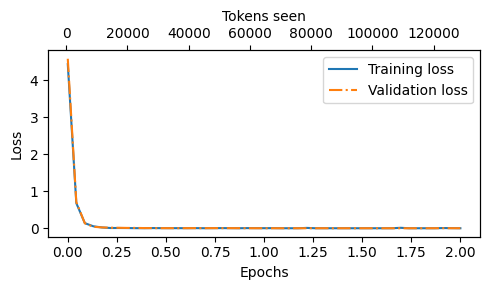

Saving trained model to a file gpt2-medium355M-sft.pth


In [35]:
# Let's train this cutie model 
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

print("Beginning training")

model_file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"

if os.path.exists(model_file_name):
    model.load_state_dict(torch.load(model_file_name))
    model.eval()
else:
    start_time = time.time()
    torch.manual_seed(123)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
    num_epochs = 2
    
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_fr=5, eval_iter=5,
        start_context=format_input(val_data.iloc[0]), tokenizer=tokenizer
    )
    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")
    
    # Plot losses...
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

    print(f"Saving trained model to a file {model_file_name}")
    torch.save(model.state_dict(), model_file_name)

In [39]:
torch.manual_seed(123)

# Preview a few examples
for _, entry in test_data.head(3).iterrows():
    entry_dict = entry.to_dict()
    input_text = format_input(entry_dict)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),  # no .to(device)
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_txt(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry_dict['output']}")
    print(f"\nModel response:\n>> {response_text}")
    print("-------------")

# Generate responses for all test data
model_responses = []
for _, entry in tqdm(test_data.iterrows(), total=len(test_data)):
    entry_dict = entry.to_dict()
    input_text = format_input(entry_dict)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),  # stays on CPU
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_txt(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    model_responses.append(response_text)

# Add new column to DataFrame
test_data["model_response"] = model_responses


Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> ................................................................................................................................................................................................................................................................
-------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> ?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

 15%|█▌        | 17/110 [2:05:18<11:25:29, 442.26s/it]


KeyboardInterrupt: 